In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)
    
    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        if training:
            x = self.dropout(x)
        return self.dense_2(x)

In [4]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()


Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [6]:
# Create a custom layer

class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
        self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs,self.w) + self.b
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)
    

tf.Tensor([[-0.11461521  0.12024755  0.0556697 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.05097866,  0.07334182,  0.04024751],
       [ 0.0173971 ,  0.09663882,  0.03011249],
       [-0.07503157, -0.0129614 , -0.05183677],
       [ 0.00480402,  0.02854538,  0.07204843],
       [-0.0108061 , -0.06531709, -0.03490196]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [7]:
# Specify trainable weights

class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal',
                             trainable = False)
        self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros',
                             trainable = False)
        
    def call(self, inputs):
        return tf.matmul(inputs,self.w) + self.b
    
dense_layer = MyLayer(3, 5)


In [8]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [9]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
        self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                      trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                   trainable=False)
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer=MyLayerMean(3, 5)

In [10]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.1182289  -0.09689799  0.04159181]


In [25]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [26]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)

In [27]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

TypeError: __init__() takes 2 positional arguments but 3 were given

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [28]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

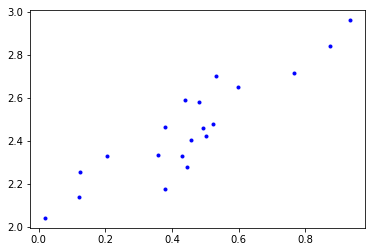

In [29]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [30]:
from tensorflow.keras.layers import Layer

In [31]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
  
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                             initializer = 'random_normal')
        self.b = self.add_weight(shape=(1,),
                             initializer = 'zeros')
    
    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.00434499 0.00376688 0.00354343 0.00123178 0.00424324 0.00488142
 0.00517764 0.00452184 0.00118957 0.00759797 0.00866501 0.00528125
 0.004978   0.00376222 0.00591463 0.00202946 0.00020155 0.00475945
 0.00924068 0.00441413], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00989882], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [32]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.074968


#### Train and plot the model

In [33]:
# Implement a gradient descent training loop for the linear regression model
learning_rate = 0.05
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)
    gradients = tape.gradient(loss, linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate*gradients[0])
    linear_regression.b.assign_sub(learning_rate*gradients[1])

    print('step %d, loss %f' % (i, loss.numpy()))


step 0, loss 6.074968
step 1, loss 4.691066
step 2, loss 3.622931
step 3, loss 2.798513
step 4, loss 2.162203
step 5, loss 1.671081
step 6, loss 1.292018
step 7, loss 0.999447
step 8, loss 0.773631
step 9, loss 0.599340
step 10, loss 0.464817
step 11, loss 0.360988
step 12, loss 0.280850
step 13, loss 0.218996
step 14, loss 0.171256
step 15, loss 0.134409
step 16, loss 0.105968
step 17, loss 0.084017
step 18, loss 0.067075
step 19, loss 0.053998
step 20, loss 0.043905
step 21, loss 0.036114
step 22, loss 0.030101
step 23, loss 0.025460
step 24, loss 0.021878


m:1,  trained m:[0.9243551]
b:2,  trained b:[1.9423776]


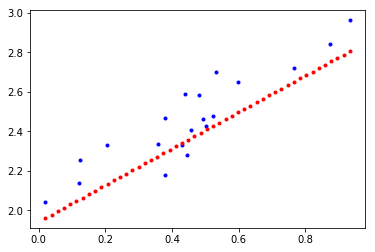

In [34]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [4]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
        self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

#### Load the reuters dataset and define the class_names 

In [6]:
# Instantiate the model object
model = MyModel(64, 10000, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.02142003 0.04403267 0.00859556 0.02055786 0.03461175 0.00603637
  0.04944095 0.04392662 0.06284486 0.02813939 0.00749678 0.01220245
  0.04599473 0.02108831 0.01721625 0.00707771 0.01357493 0.00353834
  0.0164442  0.02748774 0.01909404 0.04637385 0.00940879 0.00365195
  0.03227489 0.01203552 0.01727993 0.00563005 0.00772795 0.03429051
  0.06374495 0.00917101 0.02388624 0.00965957 0.02625114 0.0210489
  0.02570259 0.03028272 0.02163697 0.00293854 0.034156   0.01155385
  0.00425614 0.00743616 0.01495189 0.01382834]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer (MyLayer)           multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_1 (MyLayer) 

In [7]:
class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape = (input_shape[-1], self.units),
                             initializer = 'random_normal',
                             name = 'kernel')
        self.b = self.add_weight(shape = (self.units,),
                             initializer = 'zeros',
                             name = 'bias')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [8]:
# Instantiate the model object
model = MyModel(64, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.05110761 0.0179624  0.00732059 0.02148862 0.00882861 0.00346547
  0.00313879 0.00391534 0.00692865 0.0087078  0.00644566 0.00714823
  0.10276317 0.02048427 0.00910049 0.01829344 0.01187979 0.02706901
  0.01338513 0.03301912 0.00521868 0.03544619 0.01819213 0.00589729
  0.16008784 0.01378222 0.0230991  0.01364988 0.02451459 0.01550546
  0.00522879 0.01429631 0.01359653 0.01764958 0.00852835 0.02165365
  0.01833434 0.00836734 0.0058822  0.02307842 0.08944128 0.00157
  0.01285874 0.01270094 0.00540727 0.04356065]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer) 

In [35]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [36]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [37]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [38]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [39]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [40]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [15]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [20]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop
    for x, y in train_dataset:
    # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # compute current loss
        epoch_loss_avg(loss_value)
    # compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

  # End Epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_avg.result(),
                                                              epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.307, Accuracy: 47.951%
Epoch 001: Loss: 1.904, Accuracy: 61.055%
Epoch 002: Loss: 1.823, Accuracy: 65.520%
Epoch 003: Loss: 1.776, Accuracy: 67.624%
Epoch 004: Loss: 1.740, Accuracy: 68.570%
Epoch 005: Loss: 1.740, Accuracy: 68.871%
Epoch 006: Loss: 1.730, Accuracy: 69.717%
Epoch 007: Loss: 1.706, Accuracy: 69.717%
Epoch 008: Loss: 1.700, Accuracy: 70.140%
Epoch 009: Loss: 1.697, Accuracy: 70.552%
Duration :183.646


#### Evaluate the model

In [21]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [22]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [19]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

NameError: name 'weight_decay' is not defined

#### Plot the learning curves

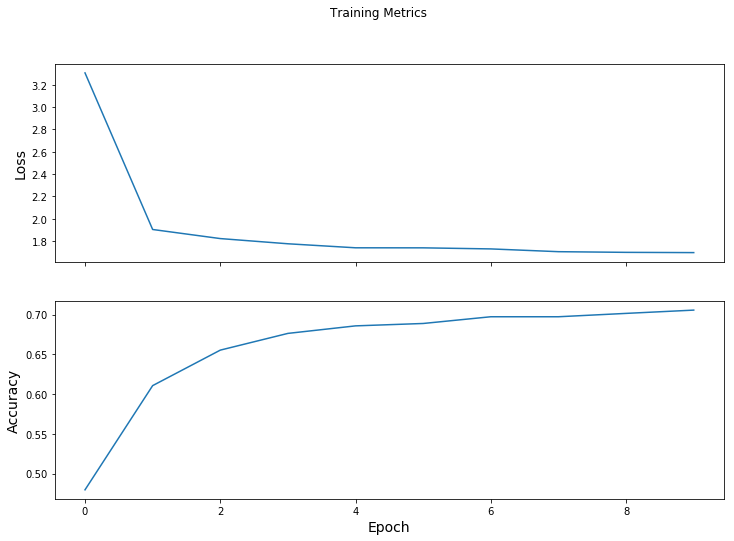

In [23]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [24]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model

# Instantiate the model object
model = MyModel(64, 64, 46)


#### Redefine the grad function using the @tf.function decorator

In [41]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [42]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop
    for x, y in train_dataset:
    # optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # compute current loss
        epoch_loss_avg(loss_value)
    # compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

  # End Epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_avg.result(),
                                                              epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 1.669, Accuracy: 70.163%
Epoch 001: Loss: 1.667, Accuracy: 70.708%
Epoch 002: Loss: 1.661, Accuracy: 71.176%
Epoch 003: Loss: 1.670, Accuracy: 71.409%
Epoch 004: Loss: 1.679, Accuracy: 71.387%
Epoch 005: Loss: 1.668, Accuracy: 71.454%
Epoch 006: Loss: 1.670, Accuracy: 71.866%
Epoch 007: Loss: 1.664, Accuracy: 71.877%
Epoch 008: Loss: 1.655, Accuracy: 71.677%
Epoch 009: Loss: 1.673, Accuracy: 72.233%
Duration :147.239


#### Print the autograph code

In [43]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('grad', 'grad_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as grad_scope:
    with tf.GradientTape() as tape:
      loss_value = ag__.converted_call(loss, grad_scope.callopts, (model, inputs, targets, wd), None, grad_scope)
    do_return = True
    retval_ = grad_scope.mark_return_value((loss_value, ag__.converted_call(tape.gradient, grad_scope.callopts, (loss_value, model.trainable_variables), None, grad_scope)))
  do_return,
  return ag__.retval(retval_)

